__This notebook has been made to plot the results with the metric which is the most comparable to the plot of the authors (last accuracy/parity/bias). Please keep in mind that:__

> This is only applicable if the provided datasets are used (german, compas and drug).

> Plots can onle be made if all the datasets together with all their attacks have been run with epsilons from 0.0 up to 1, otherwise it will most likely throw errors.

In [20]:
import glob
import csv
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

In [36]:
# seed still needs to be implemented
def get_test_dicts(dataset, data_choice, methods, folder_measure, measure):
    # make the dicts
    last_dict = {"IAF":dict(), "RAA":dict(), "NRAA":dict()}
    
    # find all the files for the dataset
    file_names = os.path.join("{}".format(data_choice), "{}".format(dataset), "{}".format(folder_measure), "*")
#     for file_name in glob.glob("{}/{}/{}/*".format(data_choice, dataset, folder_measure)):
    for file_name in glob.glob(file_names):
        for method in methods:
            if method in file_name:
                # strip the methods (/IAF-) etc. 
                meth = method[1:-1]
                splits = file_name.split("_")
                # find the epsilon in the filename 
                epsilon = [i for i in splits if "eps" in i][0].split("eps-")[1]
                data = pd.read_csv(file_name)
                # if there are nans in the data, skip them
                measured = data[~data[measure].isna()][measure]
                
                if measure == "test_acc":
                    # calculate test error
                    last_dict[meth][epsilon] = 1 - measured[measured.index[-1]]
                    
                else:
                    last_dict[meth][epsilon] = measured[measured.index[-1]] 

    return last_dict 


# same holds for this function, but this time we save the iterations and time taken
# which you have to run once for the time and one for the iterations
def get_time_and_it_dicts(dataset, data_choice, methods, time_and_it_folder, t_i_col):
    dict_ = {"IAF":dict(), "RAA":dict(), "NRAA":dict()}
    
    file_names = os.path.join("{}".format(data_choice), "{}".format(dataset), "{}".format(time_and_it_folder), "*")
#     for file_name in glob.glob("{}/{}/{}/*".format(data_choice, dataset, time_and_it_folder)):
    for file_name in glob.glob(file_names):
        for method in methods:
            if method in file_name:
                meth = method[1:-1]
                splits = file_name.split("_")
                epsilon = [i for i in splits if "eps" in i][0].split("eps-")[1]
                data = pd.read_csv(file_name)
                measured = data[~data[t_i_col].isna()][t_i_col]
                
                dict_[meth][epsilon] = measured[measured.index[-1]]
    return dict_

In [37]:
def plot_seed(datasets, data_choice, methods, folder_measure, measure, time_and_it, t_i_col):    
    # ta = test accuracy
    german_last_ta_dict = get_test_dicts(datasets[0], data_choice, methods, folder_measure[0], measures[0])
    compas_last_ta_dict = get_test_dicts(datasets[1], data_choice, methods, folder_measure[0], measures[0])
    drug_last_ta_dict = get_test_dicts(datasets[2], data_choice, methods, folder_measure[0], measures[0])
    
    
    # concat all three dicts into one df
    acc_df = pd.concat({'German acc': pd.DataFrame(german_last_ta_dict), 
                        'COMPAS acc': pd.DataFrame(compas_last_ta_dict), 
                        'Drug consumption acc': pd.DataFrame(drug_last_ta_dict)}).unstack(0).sort_index(axis = 0)
    

    # p = parity
    german_last_p_dict = get_test_dicts(datasets[0], data_choice, methods, folder_measure[1], measure[1])
    compas_last_p_dict = get_test_dicts(datasets[1], data_choice, methods, folder_measure[1], measure[1])
    drug_last_p_dict = get_test_dicts(datasets[2], data_choice, methods, folder_measure[1], measure[1])
    
    # concat all three dicts into one df
    p_df = pd.concat({'German par': pd.DataFrame(german_last_p_dict), 
                      'COMPAS par': pd.DataFrame(compas_last_p_dict), 
                      'Drug consumption par': pd.DataFrame(drug_last_p_dict)}).unstack(0).sort_index(axis = 0)

    # b = biases
    german_last_b_dict = get_test_dicts(datasets[0], data_choice, methods, folder_measure[1], measure[2])
    compas_last_b_dict = get_test_dicts(datasets[1], data_choice, methods, folder_measure[1], measure[2])
    drug_last_b_dict = get_test_dicts(datasets[2], data_choice, methods, folder_measure[1], measure[2])
    
    # concat all three dicts into one df
    b_df = pd.concat({'German bias': pd.DataFrame(german_last_b_dict), 
                      'COMPAS bias': pd.DataFrame(compas_last_b_dict), 
                      'Drug consumption bias': pd.DataFrame(drug_last_b_dict)}).unstack(0).sort_index(axis = 0)
    
    # to be able to make a plot loop
    dfs = [acc_df, p_df, b_df]
    
    ylabels = ["Test error", "Statistical parity", "Equality of opportunity"]
    lines = ['b-s', 'g-^', 'r-D']
    fig, axs = plt.subplots(3,3, figsize=(15, 10))
    axs = axs.ravel()
    
    fig.suptitle("{}".format(data_choice), fontsize=20, fontweight='heavy')
    
    for i in range(9):
        a = 0
        for j in range(0,9,3):
            t = i % 3
            
            # makes sure everything works as it has to
            if i <= 2:
                j += 0
            elif i > 2 and i <= 5:
                j += 1  
            elif i > 5:
                j += 2
                
            col = dfs[t].columns[j]
            column_data = dfs[t][col]

            axs[i].plot(column_data, lines[a], label="{}".format(column_data.name[0]))
            axs[i].set_title("{}".format(column_data.name[1].split(" ")[0]), fontweight='bold')
            axs[i].set_xlabel('Epsilon', fontweight='heavy')
            
            if "acc" in column_data.name[1]:
                axs[i].set_ylabel(ylabels[0], fontweight='heavy')
            elif "par" in column_data.name[1]:
                axs[i].set_ylabel(ylabels[1], fontweight='heavy')
            else:
                axs[i].set_ylabel(ylabels[2], fontweight='heavy')
            
            axs[i].legend(loc=9, ncol=3)
            axs[i].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4]) 
            axs[i].set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1, "", ""])
    
            a += 1
        
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.6)
    plt.show()
    
    # show time taken and number of iterations in a dataframe
    time_taken_g = pd.DataFrame(get_time_and_it_dicts(datasets[0], 
                                data_choice, methods, time_and_it, t_i_col[0])).sort_index(axis=0)
    time_taken_c = pd.DataFrame(get_time_and_it_dicts(datasets[1], 
                                data_choice, methods, time_and_it, t_i_col[0])).sort_index(axis=0)
    time_taken_d = pd.DataFrame(get_time_and_it_dicts(datasets[2], 
                                         data_choice, methods, time_and_it, t_i_col[0])).sort_index(axis=0)
    
    
    last_iter_g = pd.DataFrame(get_time_and_it_dicts(datasets[0], data_choice, 
                                                     methods, time_and_it, t_i_col[1])).sort_index(axis=0)
    last_iter_c = pd.DataFrame(get_time_and_it_dicts(datasets[1], data_choice, 
                                                     methods, time_and_it, t_i_col[1])).sort_index(axis=0)
    last_iter_d = pd.DataFrame(get_time_and_it_dicts(datasets[2], data_choice, 
                                                     methods, time_and_it, t_i_col[1])).sort_index(axis=0)
    
    german_df = pd.concat({"Time (s)":time_taken_g, "# iters":last_iter_g}).unstack(0)
    compas_df = pd.concat({"Time (s)":time_taken_c, "# iters":last_iter_c}).unstack(0)
    drug_df = pd.concat({"Time (s)":time_taken_d, "# iters":last_iter_d}).unstack(0)
    german_df.index.name = "Epsilon"
    compas_df.index.name = "Epsilon"
    compas_df.index.name = "Epsilon"
    
    display(pd.concat({"German":german_df, "COMPAS":compas_df, "Drug consumption":drug_df}))

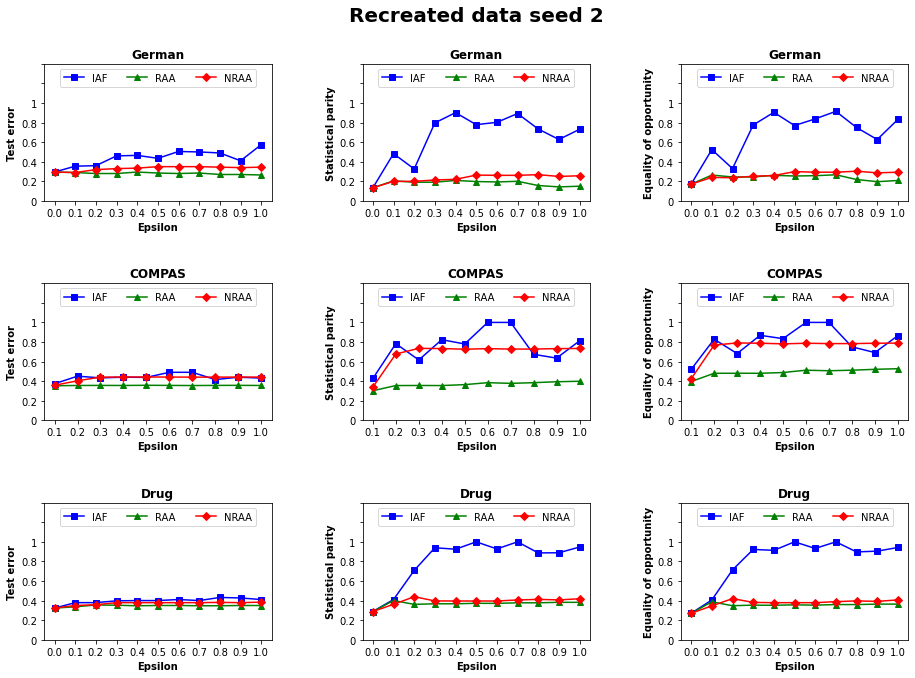

IAF                RAA                 NRAA  \
                            Time (s) # iters   Time (s) # iters     Time (s)   
                 Epsilon                                                       
German           0.1      171.161261   128.0  27.355032    28.0    63.264110   
                 0.2      152.035813    98.0  30.457471    28.0    62.206930   
                 0.3      215.213806   138.0  32.963496    28.0    62.366299   
                 0.4      185.736134   118.0  26.954541    28.0    63.130847   
                 0.5      144.672847    98.0  26.575501    28.0    68.343161   
                 0.6      216.756375   148.0  26.775113    28.0    65.350896   
                 0.7      243.409469   168.0  30.506059    28.0    62.773304   
                 0.8      214.782391   158.0  30.993225    28.0    61.687693   
                 0.9      251.397626   188.0  26.593356    28.0    69.440333   
                 1.0      258.968200   188.0  34.376949    28.0    63.676201   
COMPAS           0.1       79.500613    68.0  39.401636    28.0  6175.053773   
                 0.2      102.199277    58.0  42.892941    28.0  9267.019828   
                 0.3       82.175651    48.0  60.762992    28.0  3828.642561   
                 0.4      308.321900    68.0  46.591134    28.0  3813.736122   
                 0.5       80.327193    38.0  52.775257    28.0  3810.009634   
                 0.6      108.747840    48.0  58.740489    28.0  3793.124334   
                 0.7       88.076445    38.0  54.548193    28.0  3805.488972   
                 0.8      126.417314    58.0  69.607507    28.0  4680.612261   
                 0.9      129.166124    58.0  51.121109    28.0  5154.255518   
                 1.0      120.245426    58.0  63.052237    28.0  4427.072330   
Drug consumption 0.1       60.130336    88.0  18.293366    28.0   172.783686   
                 0.2       52.293263    68.0  22.126983    28.0   168.699791   
                 0.3       46.863622    58.0  23.364963    28.0   168.083084   
                 0.4       40.866648    48.0  18.547262    28.0   167.199779   
                 0.5       57.626810    78.0  20.108976    28.0   169.622620   
                 0.6       65.726182    78.0  20.890856    28.0   176.886195   
                 0.7       68.792372    88.0  23.074632    28.0   179.623672   
                 0.8       51.753891    58.0  20.671193    28.0   175.749799   
                 0.9       72.754462    88.0  25.533135    28.0   177.676154   
                 1.0       64.031529    78.0  25.668178    28.0   173.007029   

                                  
                         # iters  
                 Epsilon          
German           0.1        28.0  
                 0.2        28.0  
                 0.3        28.0  
                 0.4        28.0  
                 0.5        28.0  
                 0.6        28.0  
                 0.7        28.0  
                 0.8        28.0  
                 0.9        28.0  
                 1.0        28.0  
COMPAS           0.1        28.0  
                 0.2        28.0  
                 0.3        28.0  
                 0.4        28.0  
                 0.5        28.0  
                 0.6        28.0  
                 0.7        28.0  
                 0.8        28.0  
                 0.9        28.0  
                 1.0        28.0  
Drug consumption 0.1        28.0  
                 0.2        28.0  
                 0.3        28.0  
                 0.4        28.0  
                 0.5        28.0  
                 0.6        28.0  
                 0.7        28.0  
                 0.8        28.0  
                 0.9        28.0  
                 1.0        28.0

In [55]:
methods = [os.path.join(" ", "IAF-").strip(), 
           os.path.join(" ", "RAA-").strip(), 
           os.path.join(" ", "NRAA-").strip()]
folder_measures = ["test_accs", "parities and biases"]
measures = ["test_acc", "parity", "EO bias"]
datasets = ["german", "compas", "drug"]
time_and_it = "time_and_it"
time_and_it_columns = ["time_taken_seconds", "iteration"]

plot_seed(datasets, "Recreated data seed 2", methods, folder_measures, measures, 
          time_and_it, time_and_it_columns)

Make sure you **change the data_choice** (original data or authors data). So only the second parameter of plot_seed. The model automatically saves the data choice as:

    - dataset_choice: x seed y
    
with:

**x**: $\left\{\begin{array}{l}\text{Recreated data} \;\;\;\;\;\; \text { if  x == --recreated_data y} \;\; \text{OR} \;\; \text{x == --recreated_data yes} \\ \text{Authors data} \;\;\;\;\;\; \text { otherwise }\end{array}\right.$

**y**: $\left\{\begin{array}{l}y \in \{1,2,3\} \;\;\;\;\;\; \text { if  y == --rand_seed 1} \;\; \text{OR} \;\; \text{y == --rand_seed 2} \\ \text{0} \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\; \text { otherwise }\end{array}\right.$

In [48]:
methods = [os.path.join(" ", "IAF-").strip(), 
           os.path.join(" ", "RAA-").strip(), 
           os.path.join(" ", "NRAA-").strip()]
folder_measures = ["test_accs", "parities and biases"]
measures = ["test_acc", "parity", "EO bias"]
datasets = ["german", "compas", "drug"]
time_and_it = "time_and_it"
time_and_it_columns = ["time_taken_seconds", "iteration"]

In [51]:
# Make sure to change the second parameter (the seed and Authors/Original)

# plot_seed(datasets, "Authors data seed 0", methods, folder_measures, measures, 
#           time_and_it, time_and_it_columns)

'./recreated_data'